The goal of this notebook is to check the correctness of the QQt analytical solution step by step against an example done computationally

In [3]:
import gooseberry as gs 

import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from matplotlib.patches import Ellipse
import numpy as np 

import jax 
import jax.numpy as jnp
from functools import partial 

from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

In [4]:
"""
randomly initialised balanced weights of dimensions in_dim, 
hidden_dim, out_dim and balance coefficient c
""" 


def balanced_weights(in_dim, hidden_dim, out_dim, c):

    #random number bigger than c:
    a = np.random.exponential(scale = 5) + c 
    b = np.sqrt(a*a - c)

    #TODO: not sure which dimension, doesnt work for hidden_dim > min(out_dim, in_dim)
    S_1 = a * np.eye(max(hidden_dim, in_dim))[:hidden_dim, :in_dim]
    S_2 = b * np.eye(max(out_dim, hidden_dim))[:out_dim, :hidden_dim] 

    random_matrix_one = np.random.rand(hidden_dim, hidden_dim)
    random_matrix_two = np.random.rand(in_dim, in_dim)
    random_matrix_three = np.random.rand(out_dim, out_dim)

    q_one, _ = np.linalg.qr(random_matrix_one)
    q_two, _ = np.linalg.qr(random_matrix_two)
    q_three, _ = np.linalg.qr(random_matrix_three)

    U_1 = q_one 
    V_2 = q_one 
    V_1 = q_two
    U_2 = q_three

    W1 = U_1 @ S_1 @ (V_1.T)
    W2 = U_2 @ S_2 @ (V_2.T)

    return W1, W2 



In [5]:
def check_balance(w1, w2):
    return w1 @ w1.T - w2.T @ w2 

In [6]:
w1, w2 = balanced_weights(4, 4, 4, 2)

check_balance(w1, w2)

array([[ 2.00000000e+00,  2.69571873e-14, -3.41849905e-14,
         3.08391836e-14],
       [ 2.69571873e-14,  2.00000000e+00, -5.17079554e-14,
         3.52540841e-15],
       [-3.41849905e-14, -5.17079554e-14,  2.00000000e+00,
        -2.71124754e-15],
       [ 3.08391836e-14,  3.52540841e-15, -2.71124754e-15,
         2.00000000e+00]])

AssertionError: X not whitened

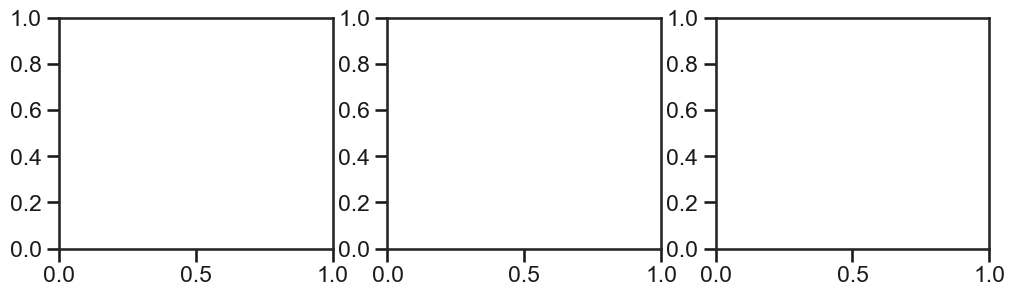

In [100]:
np.random.seed(1)

in_dim = 5
hidden_dim = 10
out_dim = 2

batch_size = 1
learning_rate = 0.1
training_steps = 400

plot_items_n = 4
blind_colours = BlindColours().get_colours()

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
train, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    task = gs.tasks.FullBatchLearning(train)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    losses = []
    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])
    
    X, Y = train(None)
    # print(X, Y)
    # analytical = analytical_euler(init_w1, init_w2, X, Y,batch_size)
    analytical = QQT(init_w1, init_w2, X.T, Y.T, True)
    analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, target in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="Analytical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")

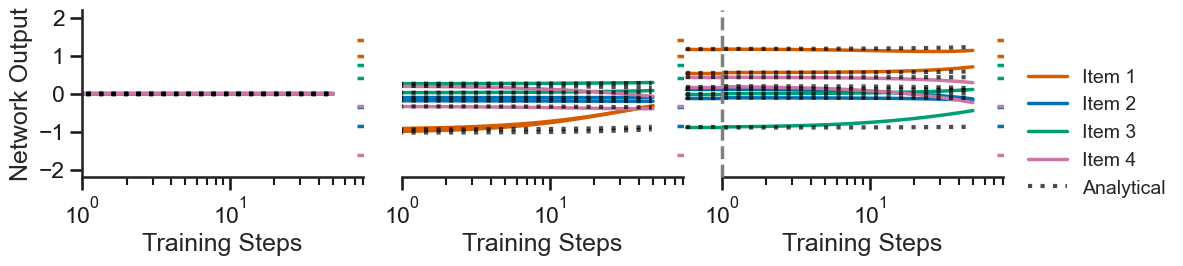

In [190]:
np.random.seed(1)

in_dim = 5
hidden_dim = 10
out_dim = 2

batch_size = 10
learning_rate = 0.01
training_steps = 50

plot_items_n = 4
blind_colours = BlindColours().get_colours()

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
train, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    task = gs.tasks.FullBatchLearning(train)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    losses = []
    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])
    
    X, Y = train(None)
    analytical = analytical_euler(init_w1, init_w2, X, Y)
    # analytical = QQT(init_w1, init_w2, X.T, Y.T, True)
    # analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, target in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="Analytical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")

In [119]:
np.asarray(ws[:3])

array([[[[ 1.2501757e-04,  3.8394789e-04, -1.0329639e-04,
           8.0817757e-05, -3.6776072e-04],
         [-1.5681733e-03, -3.2734799e-06,  1.9824882e-04,
           3.5485064e-04, -4.4906815e-04]]],


       [[[-5.0692339e-05,  3.4286667e-04, -8.3742125e-05,
           1.3481437e-04, -3.9387334e-04],
         [-1.6428637e-03, -9.3429764e-05,  2.4288138e-04,
           4.3071841e-04, -4.4630369e-04]]],


       [[[-2.3573849e-04,  2.9371073e-04, -5.8311067e-05,
           2.0159049e-04, -4.2509986e-04],
         [-1.7354252e-03, -1.9344052e-04,  2.9055378e-04,
           5.1964796e-04, -4.4755783e-04]]]], dtype=float32)

In [196]:
def analytical_euler(init_w1, init_w2, X, Y, batch_size = batch_size, learning_rate = learning_rate, training_steps = training_steps):

    # print(X)
    # print(Y)
    c = 0
    Q0 = np.vstack([init_w1.T, init_w2])

    QQt0 = Q0 @ Q0.T

    required_shape = (init_w2@init_w1).shape
    

    # print(X.T.shape)
    # print(Y.shape)
    # sigma_xy= (1. / batch_size) * X @ Y.T
    sigma_xy = Y.T @ X
    # print(sigma_xy)

    F = np.vstack([
        np.hstack([c / 2 * np.eye(sigma_xy.shape[1]), sigma_xy.T]),
        np.hstack([sigma_xy, c / 2 * np.eye(sigma_xy.shape[0])])
    ]) 

    QQts = [QQt0]
    w2w1s = [[QQt0[-required_shape[0]:, :required_shape[1]]]]

    for i in range(training_steps):
        curr = QQts[-1]
        # print(curr)
        # print(F)
        derivative = F @ curr + curr @ F - curr @ curr.T
        next = curr + learning_rate * learning_rate * derivative
        QQts.append(next)
        # print(next.shape)
        w2w1s.append(np.array([next[-required_shape[0]:, :required_shape[1]]]))

    return np.array(w2w1s)


In [197]:
task = gs.tasks.FullBatchLearning(train)
optimiser = gs.GradientDescent(learning_rate)
loss = gs.MeanSquaredError()

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)

mlp = gs.Network([
    gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
    gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
])

trainer = gs.Trainer(task, mlp, loss, optimiser)
state, params = gs.assemble(1)

losses = []
ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]

for training_step in range(training_steps):
    state, params, loss = trainer(state, params)
    losses.append(loss)
    ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])

X, Y = train(None)
analytical = analytical_euler(init_w1, init_w2, X, Y)

In [198]:
ws

[Array([[[-0.00650649, -0.19485283,  0.09915432,  0.14680646,
          -0.38114735],
         [ 0.07992728,  0.04005035, -0.308602  , -0.20657755,
          -0.06287549]]], dtype=float32),
 Array([[[-0.01010195, -0.19536485,  0.09892009,  0.14808835,
          -0.3788448 ],
         [ 0.0786678 ,  0.03725093, -0.30369887, -0.20217608,
          -0.06362464]]], dtype=float32),
 Array([[[-0.01366518, -0.19588998,  0.09868366,  0.14936492,
          -0.3766002 ],
         [ 0.07742456,  0.03450822, -0.29891714, -0.19787316,
          -0.0643788 ]]], dtype=float32),
 Array([[[-0.01719802, -0.19642848,  0.09844522,  0.15063708,
          -0.37441176],
         [ 0.0761961 ,  0.03181967, -0.29425254, -0.19366471,
          -0.06513774]]], dtype=float32),
 Array([[[-0.02070224, -0.19698068,  0.09820499,  0.15190563,
          -0.37227792],
         [ 0.07498106,  0.02918282, -0.289701  , -0.18954691,
          -0.06590122]]], dtype=float32),
 Array([[[-0.02417955, -0.19754682,  0.09796314,  

In [199]:
analytical

array([[[[-0.0065065 , -0.19485282,  0.09915433,  0.14680647,
          -0.38114732],
         [ 0.07992728,  0.04005035, -0.30860203, -0.20657757,
          -0.06287549]]],


       [[[-0.00687986, -0.19506993,  0.0992433 ,  0.14707701,
          -0.38122645],
         [ 0.07985786,  0.03981568, -0.30833223, -0.2062927 ,
          -0.06295742]]],


       [[[-0.00725346, -0.19528729,  0.09933215,  0.14734768,
          -0.38130595],
         [ 0.07978845,  0.03958115, -0.30806271, -0.20600805,
          -0.06303956]]],


       [[[-0.0076273 , -0.19550489,  0.09942087,  0.14761848,
          -0.38138582],
         [ 0.07971903,  0.03934675, -0.30779346, -0.20572363,
          -0.06312192]]],


       [[[-0.00800139, -0.19572275,  0.09950948,  0.14788942,
          -0.38146606],
         [ 0.07964961,  0.03911248, -0.30752449, -0.20543942,
          -0.0632045 ]]],


       [[[-0.00837573, -0.19594086,  0.09959796,  0.14816049,
          -0.38154667],
         [ 0.07958018,  0.03887835

In [214]:
diff = [max(analytical[i][0] - ws[i][0]), max(analytical[i][1] - ws[i][1])) for i in range(len(ws))]

In [212]:
diff

[Array([[-1.3969839e-09,  0.0000000e+00,  7.4505806e-09,  0.0000000e+00,
          2.9802322e-08],
        [ 0.0000000e+00, -3.7252903e-09, -2.9802322e-08, -1.4901161e-08,
          7.4505806e-09]], dtype=float32),
 Array([[ 0.0032221 ,  0.00029492,  0.00032321, -0.00101134, -0.00238165],
        [ 0.00119007,  0.00256475, -0.00463337, -0.00411662,  0.00066721]],      dtype=float32),
 Array([[ 0.00641172,  0.00060269,  0.00064849, -0.00201724, -0.00470573],
        [ 0.00236388,  0.00507293, -0.00914556, -0.00813489,  0.00133923]],      dtype=float32),
 Array([[ 0.00957072,  0.00092359,  0.00097565, -0.00301859, -0.00697404],
        [ 0.00352293,  0.00752708, -0.01354092, -0.01205891,  0.00201582]],      dtype=float32),
 Array([[ 0.01270085,  0.00125793,  0.00130449, -0.00401621, -0.00918815],
        [ 0.00466856,  0.00992967, -0.01782349, -0.01589251,  0.00269672]],      dtype=float32),
 Array([[ 0.01580382,  0.00160596,  0.00163482, -0.00501086, -0.0113498 ],
        [ 0.00580212, 

In [105]:
import numpy as np

# Create a sample matrix
matrix = np.array([
    [1, 2, 3, 4, 5, 6],
    [7, 8, 9, 10, 11, 12],
    [13, 14, 15, 16, 17, 18],
    [19, 20, 21, 22, 23, 24]
])

# Get the last two rows and first five columns
result = matrix[-2:, :5]

print("Original matrix:")
print(matrix)

print("\nResult:")
print(result)

Original matrix:
[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]
 [13 14 15 16 17 18]
 [19 20 21 22 23 24]]

Result:
[[13 14 15 16 17]
 [19 20 21 22 23]]
